# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import warnings
from matplotlib import rc
rc('text', usetex=True)
warnings.filterwarnings('ignore')

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy

import warnings

# m(a) correlation plots

In [5]:
from relaxed.analysis import add_box_indices, vol_jacknife_values, setup, get_m_a_corrs, get_fractional_tdyn

In [6]:
names = ['m11', 'm12']
params = ['cvir', 'x0', 'v0', 't/|u|', 'q', 'phi_l']
latex_params = ['c_{\\rm vir}', 'x_{\\rm off}', 'v_{\\rm off}', 't/|u|', 'q', '\\Phi_{L}']
colors = ['r','b', 'g', 'm', 'k', 'y']
markers = np.array(['.', 'x'])

In [7]:
# get the jacknife errors for each index in indices for each param for each cat. 
errs = {name:{} for name in names}
for i,name in enumerate(names):
    hcat, indices, scales = setup(name)
    add_box_indices(hcat.cat)
    for j, param in enumerate(params):
        values = vol_jacknife_values(get_m_a_corrs, hcat.cat, param, indices)
        errs[name][param] = np.sqrt(values.var(axis=0)*7)

## m_a correlations

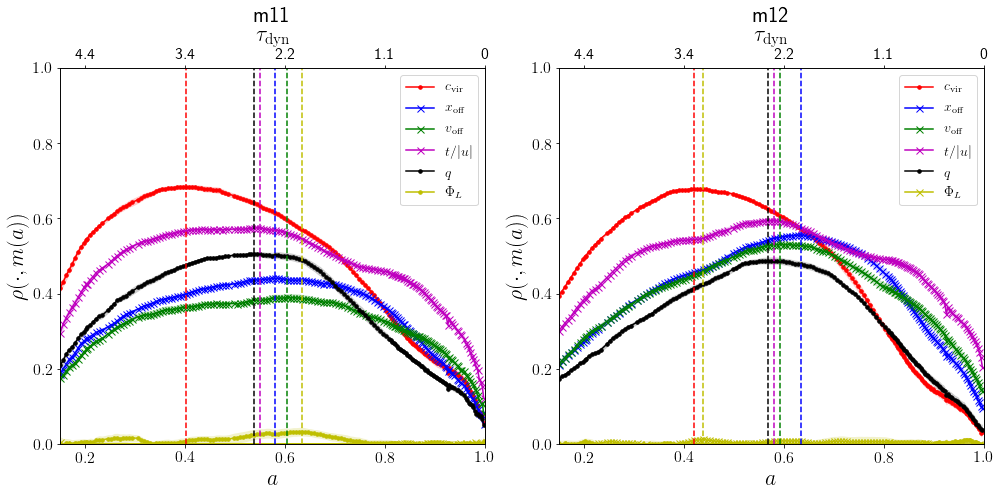

In [8]:
fig, axes = plt.subplots(1,len(names),figsize=(len(names)*7,7))
axes = axes.flatten() if len(names) > 1 else [axes]
for i, name in enumerate(names):
    hcat, indices, scales = setup(name)
    ax = axes[i]
    max_scales = [0.]*len(params)
    tdyn = np.mean(hcat.cat['tdyn']) / 10**9 #Gyr which astropy also returns by default

    for j, param in enumerate(params):
        latex_param = latex_params[j]
        color = colors[j]
        corrs = get_m_a_corrs(hcat.cat, param, indices)
        err = errs[name][param]
        pos = corrs > 0 
        neg = ~pos
        corrs = abs(corrs)
        
        # plot positive corr and negative corr with different markers. 
        if sum(pos) > 0:
            label = f'${latex_param}$' if sum(pos) > sum(neg) else None
            ax.plot(scales[pos], corrs[pos], color=color, marker=markers[0], label=label, markersize=7)
            
        if sum(neg) > 0:
            label = f'${latex_param}$' if sum(pos) < sum(neg) else None
            ax.plot(scales[neg], corrs[neg], color=color, marker=markers[1], label=label, markersize=7)
            
        max_scales[j] = scales[np.nanargmax(abs(corrs))]
        
        nan_indx = np.isnan(err)
        err[nan_indx] = 0. 
        y1 = corrs - err
        y2 = corrs + err
        ax.fill_between(scales, y1, y2, alpha=0.2, linewidth=0.001, color=color)
        
                
    # draw a vertical line at max scales
    for j, s in enumerate(max_scales):
        color = colors[j]
        ax.axvline(s, linestyle='--', color=color)
        

    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 1.0)
    ax.set_title(name, size=22)
    ax.set_ylabel(f"$\\rho(\\cdot, m(a))$", size=22)
    ax.set_xlabel(f"$a$", size=22)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # add additional x-axis with tydn fractional scale
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    
    fractional_tdyn = get_fractional_tdyn(ax.get_xticks(), tdyn, sim_name='Bolshoi')
    fractional_tdyn = np.array([f'{x:.2g}' for x in fractional_tdyn])
    ax2.set_xticklabels(fractional_tdyn, size=16)
    ax2.set_xlabel("$\\tau_{\\rm dyn}$", size=22)
    
    ax.legend(loc='best', prop={'size': 14})
    
    ax.set_xlim(0.15, 1)
    ax2.set_xlim(0.15 , 1)
plt.tight_layout()
plt.show()

# a(m) correlations

In [9]:
from relaxed.analysis import setup, get_am_corrs, get_am

In [10]:
names = ['m11', 'm12']
params = ['cvir', 'x0', 'v0', 't/|u|', 'q', 'phi_l']
latex_params = ['c_{\\rm vir}', 'x_{\\rm off}', 'v_{\\rm off}', 't/|u|', 'q', '\\Phi_{L}']
colors = ['r','b', 'g', 'm', 'k', 'y']
markers = np.array(['.', 'x'])

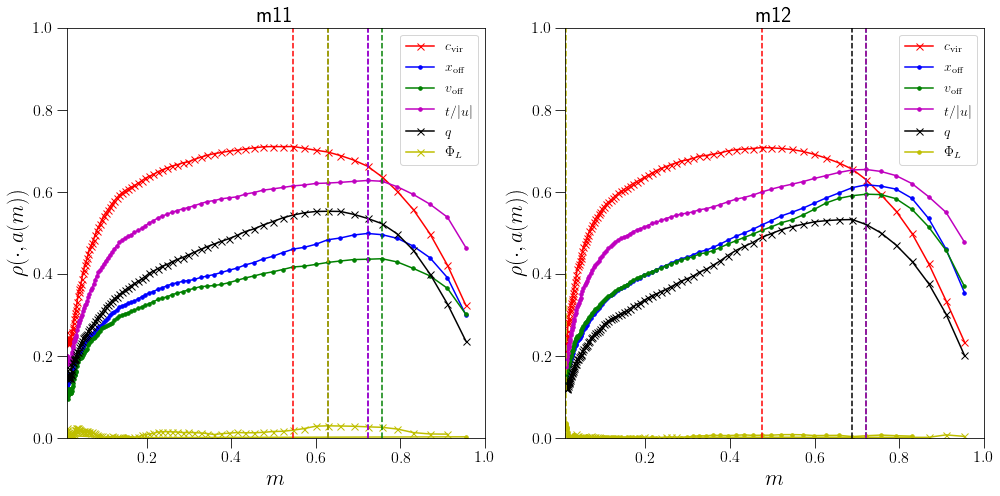

In [11]:
fig, axes = plt.subplots(1,len(names),figsize=(len(names)*7,7))
axes = axes.flatten() if len(names) > 1 else [axes]
for i, name in enumerate(names):
    hcat, indices, scales = setup(name)
    am, mass_bins = get_am(name)
    ax = axes[i]
    max_mass_bins = [0.]*len(params)

    for j, param in enumerate(params):
        latex_param = latex_params[j]
        color = colors[j]
        corrs = get_am_corrs(hcat.cat, param, am)
        pos = corrs >= 0 
        neg = ~pos
        corrs = abs(corrs)
        
        # plot positive corr and negative corr with different markers. 
        if sum(pos) > 0:
            label = f'${latex_param}$' if sum(pos) > sum(neg) else None
            ax.plot(mass_bins[pos], corrs[pos], color=color, marker=markers[0], label=label, markersize=7)
            
        if sum(neg) > 0:
            label = f'${latex_param}$' if sum(pos) < sum(neg) else None
            ax.plot(mass_bins[neg], corrs[neg], color=color, marker=markers[1], label=label, markersize=7)
            
        max_mass_bins[j] = mass_bins[np.nanargmax(abs(corrs))]
    
        
                
    # draw a vertical line at max scales
    for j, mbin in enumerate(max_mass_bins):
        color = colors[j]
        ax.axvline(mbin, linestyle='--', color=color)
        

    ax.set_ylim(0, 1.0)
    ax.set_xlim(0.01, 1.0)
#     ax.set_xscale('log')
    
    ax.set_title(name, size=22)
    ax.set_ylabel(f"$\\rho(\\cdot, a(m))$", size=22)
    ax.set_xlabel(f"$m$", size=22)
    ax.tick_params(axis='both', which='major', labelsize=16, size=10)    
    ax.tick_params(axis='x', which='minor', size=8)    
    ax.legend(loc='best', prop={'size': 14})

plt.tight_layout()
plt.show()